In [1]:
from model.modules import *
from model.modules.cadCAD import *

from model.bonding import *
# from model.helpers import *

In [3]:
# Import Swarm notebook

# import sys
# import jupyter
# sys.meta_path.append(jupyter.NotebookFinder())
# %matplotlib notebook
# import swarm
# %matplotlib inline

## **Described Bonding Formula**

$$
f(x) = C x^{\frac{1}{n}}
$$

At a token supply of investor issuance + developer issuance, where C is a constant and p is the price point after initial token issuance:

$$
\begin{aligned}
x & = inv + dev \\
p & = C (inv + dev)^{1/n} \\
C & = p / (inv + dev)^{1/n} \\
\end{aligned}
$$

In [1]:
# f(x) = K*x^(RR)
# integral f = (1/RR)*K*x^(RR - 1)
# n == reserve ratio
# C == K/RR

## **Bancor Bonding Formulae**

References:
* https://drive.google.com/file/d/0B3HPNP-GDn7aRkVaV3dkVl9NS2M/view
* https://yos.io/2018/11/10/bonding-curves/

### **Continuous token price**

$$
P(x) = \frac{RB}{CS * RR}
$$

Where:
$$
\begin{aligned}
RB & \equiv \text{Reserve token balance} \\
CS & \equiv \text{Continuous token supply} \\
RR & \equiv \text{Reserve ratio} \\
\end{aligned}
$$

and

$$
RR = \frac{RB}{CS*CP}
$$

Where:
$$
CP \equiv \text{Continuous token price}
$$

### **Integral**

$$
\int_{}^{} f(x) dx = CS * ((\frac{1 + x}{RB})^{RR} - 1)
$$

Where:

$$
x \equiv \text{The reserve tokens received}
$$

### **Inverse integral**

$$
\int_{}^{} f(x)^{-1} dx = RB * (1-(\frac{1-x}{CS})^{\frac{1}{RR}})
$$

Where:

$$
x \equiv \text{Continuous tokens received}
$$

In [192]:
# Usual scale on Ethereum
scl = 1e18
reserve_ratio = 1.0/5
presale_price = 1

# Assuming we start at a supply and reserve, after initial raise, of:
initial_raise = 3*1e6*scl
premine = initial_raise
initial_reserve = initial_raise + premine

initial_dev_supply = premine/(presale_price*reserve_ratio)

initial_supply = initial_reserve/(presale_price*reserve_ratio)

initial_inv_supply = initial_supply - initial_dev_supply

max_supply = initial_supply*2

def bonding_function(x):
    return pow(x, (int(1/reserve_ratio) - 1))

print(premine)
print(initial_dev_supply)
print(initial_supply)

3e+24
1.4999999999999998e+25
2.9999999999999996e+25


2.9999999999999996e+25


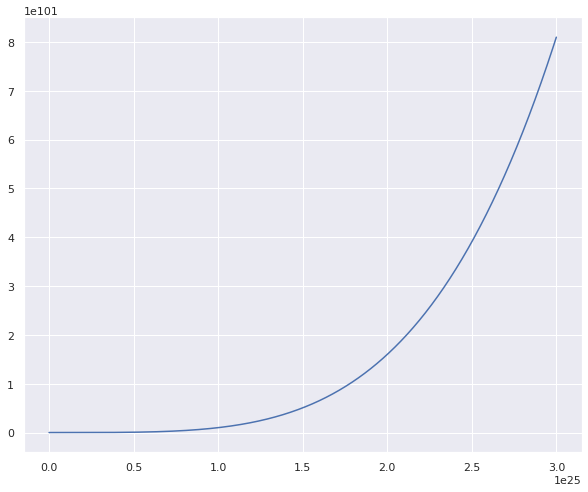

In [193]:
%matplotlib inline
%config InlineBackend.close_figures=False # keep figures open in pyplot

import seaborn as sns
sns.set(rc={'figure.figsize':(10,8)})

x = range(1, int(initial_supply), int(initial_supply / 1000))
y = map(bonding_function, x)

bancor_curve, = plt.plot(list(x), list(y))

print(initial_supply)

---

## **Conversion of "BC" script formulae**

In [194]:
# Usual scale on Ethereum
scl = 1e18

# log2 of reserve ratio
n = 5

# Also, initially 1 BZZ = res DAI
res = 2**n

# 3M DAI
initial_raise = scl*3*1e6

# 3M DAI
premine = initial_raise

# 6M DAI worth of token issued initially
issue = initial_raise + premine

# Premined developer tokens
bzzpremine = premine/res

# Initial supply in BZZ
# initial_supply = issue/res

# Investor tokens
bzzinvestor = initial_supply - bzzpremine

# Maximal supply in BZZ
max_supply = initial_supply*2

In [195]:
# Helper functions and constants
def nth_square(x, n):
    y = x
    for i in range(1, n):
        x = (x*x) / initial_supply
    return x+y

coeff = (nth_square(initial_supply + scl, n) - nth_square(initial_supply, n))
print(coeff)

# Primitive function of price function
def prf(x):
    return x + (res-1)*scl*nth_square(x, n) / coeff

# Note: this is great for calculating
# the price of 1 token, but fails for
# calculting the price of many tokens.
# For this you need the integral of the
# primitive function. The same applies
# for calculating the sale price, where
# you need the inverse integral. Neither
# of these functions are necessarily
# feasible in solidity, which is why Bancor
# uses a function with the idea of a 
# connector weight and fixed reserve ratio.

# Price of 1 token at supply x
def pr(x):
    return prf(x+scl) - prf(x)

1.700000407113171e+19


In [196]:
# Primitive function of price function
def prf_decomposed(supply):
    return x + 31*1e18*nth_square(supply, 5) / (nth_square(initial_supply + scl, 5) - nth_square(initial_supply, 5))

In [197]:
print(nth_square(initial_supply + scl, 5) - nth_square(initial_supply, 5))
print(nth_square(initial_supply, 5))

1.700000407113171e+19
5.999999999999995e+25


In [198]:
# DAI available immediately 
collect = initial_raise - (prf(initial_supply)-prf(0))
collect

-1.364117385041412e+26

In [199]:
# Worst case DAI value of premine (everybody else cashes out before)
worst = prf(bzzpremine) - prf(0)
worst

2.6470584141272073e+23

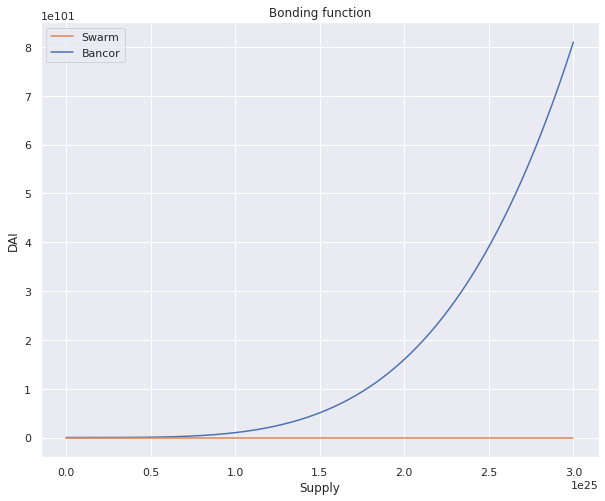

2.9999999999999996e+25


In [200]:
x = range(1, int(initial_supply), int(initial_supply / 1000))
y = map(prf, list(x))

swarm_curve, = plt.plot(list(x), list(y))

plt.legend([swarm_curve, bancor_curve], ['Swarm', 'Bancor'])

plt.title('Bonding function')
plt.ylabel('DAI')
plt.xlabel('Supply')
plt.show()

print(initial_supply)

In [201]:
# 0.8*x^(32-1)
# https://www.wolframalpha.com/input/?i=0.8*x%5E%2832-1%29

# ± (1.12218 x^(1/32))
# https://www.wolframalpha.com/input/?i=inverse+integral+of+0.8*x%5E%2832-1%29

In [ ]:
# https://yos.io/2018/11/10/bonding-curves/

In [ ]:
# https://en.wikipedia.org/wiki/Talk%3ANth_root_algorithm#Too_long_runtime_in_Python

In [ ]:
print("Creating mesh grid")

s = np.linspace(initial_supply, initial_supply*2, 100)
p1 = primitive_function(initial_supply)
p2 = primitive_function(initial_supply*2)
p = np.linspace(p1, p2, 100)

X, Y = np.meshgrid(s, p)

print("Calculating valuations")

buy_in = 1e18 # 1 Dai

def valuation(current_supply, buy_in_supply):
    primitive_function(current_supply)
    token_reward = collateral_to_token_selling(buy_in, buy_in_supply, gradient)
    pool_balance = curve_integral(current_supply, gradient)
    valuation = reward_for_burn(token_reward, current_supply, pool_balance, gradient) # (pool_balance*token_reward)/max(1, current_supply)
    return max(0, (valuation - buy_in)/buy_in)

np_func = np.frompyfunc(valuation, 2, 1)

Z = np.nan_to_num(np_func(X, Y))

print("Creating surface")

surface = go.Surface(x=X, y=Y, z=Z)
data = [surface]

layout = go.Layout(
    title='Valuation Plot',
    scene=dict(
        xaxis=dict(
            title='Supply',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            title='Buy-in supply',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            title='ROI %',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        )
    )
)

print("Plotting figure")

# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig, filename='valuation_plot')

plt.contourf(X,Y,Z)
plt.colorbar()
plt.title('Value (ROI) distribution heatmap')
plt.xlabel('Supply')
plt.ylabel('Buy-in supply')
plt.savefig('Value (ROI) distribution heatmap.png')
plt.show()

In [ ]:
def invariant(reserve, supply, k):
    return supply**k/reserve

def rratio(reserve, supply, price):
    return reserve / (supply * price)

def hatch_supply(initial_deposit, initial_price):
    return initial_deposit/initial_price

def bonding_curve(x, rratio):
    return x**(rratio - 1)

def spot_price(reserve, supply, k):
    return k*(reserve/supply)

def mint(collateral, reserve, supply, k):
    return supply**k * ((1 + collateral / reserve) - 1)

def withdraw(tokens, reserve, supply, k):
    return reserve * (1 - (1 - tokens / supply)**k)